# Umbrales de Clasificación: Ajustando las Predicciones

En este notebook exploraremos cómo el cambio de umbral en un modelo de clasificación binaria afecta las predicciones y las métricas de desempeño.

## ¿Qué es el umbral de clasificación?

Los modelos de clasificación binaria generan **probabilidades** (valores entre 0 y 1). Para convertir estas probabilidades en predicciones de clase, necesitamos un **umbral**:

- Si `P(clase=1) >= umbral` → Predecir clase 1
- Si `P(clase=1) < umbral` → Predecir clase 0

**Por defecto, el umbral es 0.5**, pero esto no siempre es óptimo, especialmente con clases desbalanceadas.

In [1]:
# Instalación de dependencias (descomentar si es necesario)
# !pip install lightgbm scikit-learn pandas matplotlib seaborn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, 
    classification_report,
    precision_score, 
    recall_score, 
    f1_score,
    roc_curve,
    auc
)
import lightgbm as lgb

# Configuración
sns.set_style("whitegrid")
np.random.seed(42)

## 1. Generación de Datos Sintéticos Desbalanceados

Creamos un dataset donde la clase positiva (1) representa solo el 10% de los datos. Esto simula escenarios reales como detección de fraude, diagnóstico de enfermedades raras, etc.

In [3]:
# Generar dataset desbalanceado
X, y = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=15,
    n_redundant=5,
    n_classes=2,
    weights=[0.9, 0.1],  # 90% clase 0, 10% clase 1
    flip_y=0.01,
    random_state=42
)

# Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Visualizar el desbalance
print("Distribución de clases en entrenamiento:")
print(pd.Series(y_train).value_counts())
print(f"\nProporción clase 1: {y_train.mean():.2%}")

Distribución de clases en entrenamiento:
0    629
1     71
Name: count, dtype: int64

Proporción clase 1: 10.14%


## 2. Entrenamiento del Modelo LightGBM

Entrenamos un modelo LightGBM que nos dará probabilidades para cada observación.

In [4]:
# Crear y entrenar el modelo
model = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    verbose=-1
)

model.fit(X_train, y_train)

# Obtener probabilidades (esto es clave para ajustar umbrales)
y_proba = model.predict_proba(X_test)[:, 1]  # Probabilidad de clase 1

print("Modelo entrenado exitosamente")
print(f"Rango de probabilidades: [{y_proba.min():.3f}, {y_proba.max():.3f}]")

Modelo entrenado exitosamente
Rango de probabilidades: [0.000, 0.997]


## 3. Predicciones con Umbral por Defecto (0.5)

Primero, veamos cómo se comporta el modelo con el umbral estándar de 0.5.

Métricas con umbral = 0.5
              precision    recall  f1-score   support

     Clase 0       0.92      0.99      0.95       269
     Clase 1       0.78      0.23      0.35        31

    accuracy                           0.91       300
   macro avg       0.85      0.61      0.65       300
weighted avg       0.90      0.91      0.89       300



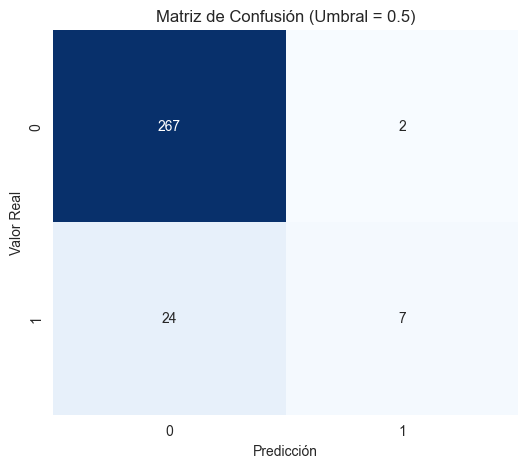

In [5]:
# Predicciones con umbral 0.5 (default)
threshold_default = 0.5
y_pred_default = (y_proba >= threshold_default).astype(int)

print(f"Métricas con umbral = {threshold_default}")
print("="*50)
print(classification_report(y_test, y_pred_default, target_names=['Clase 0', 'Clase 1']))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_default)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Matriz de Confusión (Umbral = {threshold_default})')
plt.ylabel('Valor Real')
plt.xlabel('Predicción')
plt.show()

## 4. Ajustando el Umbral: Experimentación

Ahora probemos diferentes umbrales y veamos cómo cambian las métricas.

**Trade-off clave:**
- **Umbral bajo** → Más predicciones positivas → Mayor Recall, menor Precision
- **Umbral alto** → Menos predicciones positivas → Menor Recall, mayor Precision

In [6]:
# Probar diferentes umbrales
thresholds_to_test = [0.1, 0.3, 0.5, 0.7, 0.9]
results = []

for threshold in thresholds_to_test:
    y_pred = (y_proba >= threshold).astype(int)
    
    results.append({
        'Umbral': threshold,
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'Predicciones Positivas': y_pred.sum()
    })

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

 Umbral  Precision   Recall  F1-Score  Predicciones Positivas
    0.1   0.645161 0.645161  0.645161                      31
    0.3   0.750000 0.290323  0.418605                      12
    0.5   0.777778 0.225806  0.350000                       9
    0.7   0.777778 0.225806  0.350000                       9
    0.9   0.666667 0.129032  0.216216                       6


### Visualización del Trade-off Precision-Recall

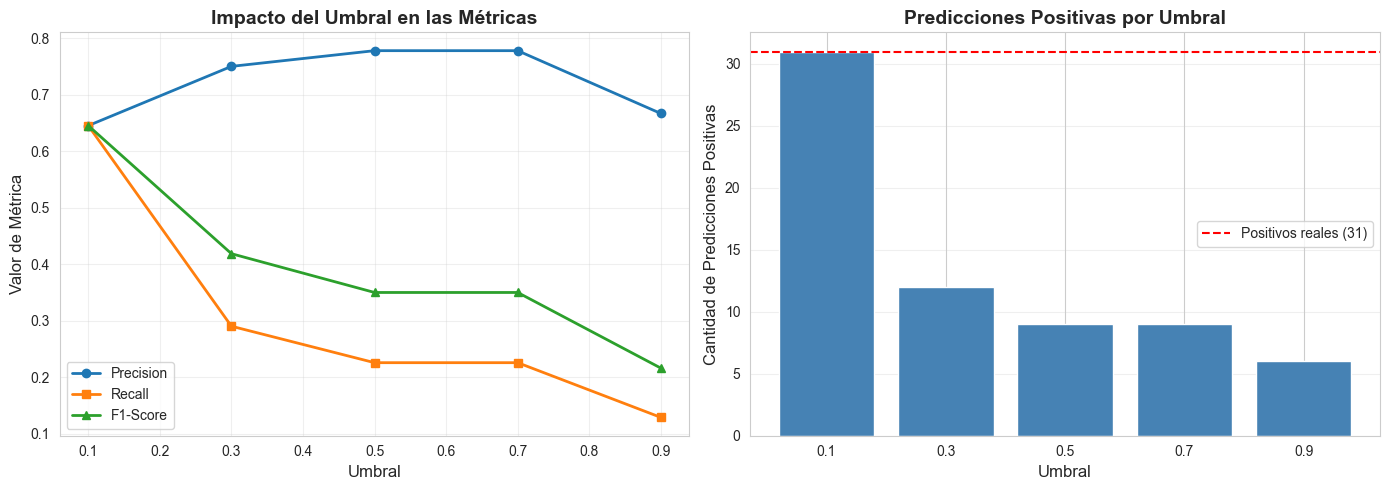

In [7]:
# Gráfico de Precision vs Recall vs F1
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Precision y Recall vs Umbral
ax[0].plot(results_df['Umbral'], results_df['Precision'], marker='o', label='Precision', linewidth=2)
ax[0].plot(results_df['Umbral'], results_df['Recall'], marker='s', label='Recall', linewidth=2)
ax[0].plot(results_df['Umbral'], results_df['F1-Score'], marker='^', label='F1-Score', linewidth=2)
ax[0].set_xlabel('Umbral', fontsize=12)
ax[0].set_ylabel('Valor de Métrica', fontsize=12)
ax[0].set_title('Impacto del Umbral en las Métricas', fontsize=14, fontweight='bold')
ax[0].legend()
ax[0].grid(True, alpha=0.3)

# Plot 2: Número de predicciones positivas
ax[1].bar(results_df['Umbral'].astype(str), results_df['Predicciones Positivas'], color='steelblue')
ax[1].axhline(y=y_test.sum(), color='red', linestyle='--', label=f'Positivos reales ({y_test.sum()})')
ax[1].set_xlabel('Umbral', fontsize=12)
ax[1].set_ylabel('Cantidad de Predicciones Positivas', fontsize=12)
ax[1].set_title('Predicciones Positivas por Umbral', fontsize=14, fontweight='bold')
ax[1].legend()
ax[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 5. Curva ROC y Selección Óptima de Umbral

La curva ROC muestra el desempeño del modelo para todos los umbrales posibles.

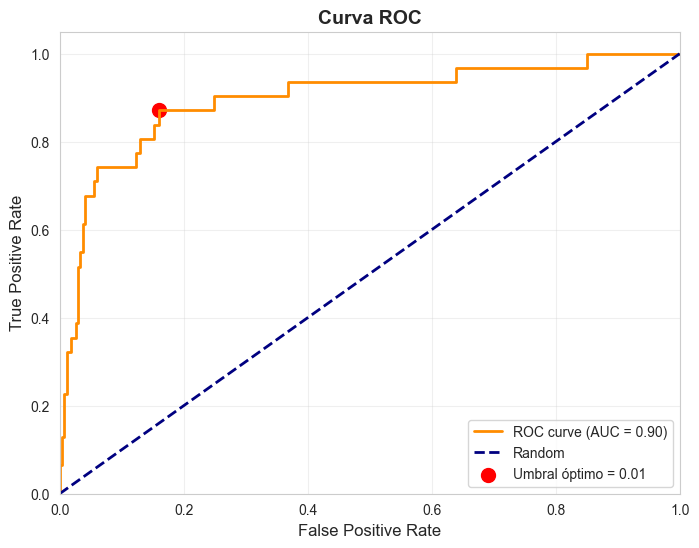


Umbral óptimo sugerido (maximizando J de Youden): 0.011


In [8]:
# Calcular curva ROC
fpr, tpr, thresholds_roc = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Encontrar el umbral óptimo (maximizar J = TPR - FPR)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds_roc[optimal_idx]

# Graficar ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', s=100, 
            label=f'Umbral óptimo = {optimal_threshold:.2f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Curva ROC', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nUmbral óptimo sugerido (maximizando J de Youden): {optimal_threshold:.3f}")

## 6. Comparación Final: Umbral Default vs Umbral Óptimo

In [9]:
# Predicciones con umbral óptimo
y_pred_optimal = (y_proba >= optimal_threshold).astype(int)

print(f"COMPARACIÓN DE UMBRALES")
print("="*70)
print(f"\nUmbral = 0.5 (Default)")
print("-"*70)
print(classification_report(y_test, y_pred_default, target_names=['Clase 0', 'Clase 1']))

print(f"\nUmbral = {optimal_threshold:.3f} (Óptimo)")
print("-"*70)
print(classification_report(y_test, y_pred_optimal, target_names=['Clase 0', 'Clase 1']))

COMPARACIÓN DE UMBRALES

Umbral = 0.5 (Default)
----------------------------------------------------------------------
              precision    recall  f1-score   support

     Clase 0       0.92      0.99      0.95       269
     Clase 1       0.78      0.23      0.35        31

    accuracy                           0.91       300
   macro avg       0.85      0.61      0.65       300
weighted avg       0.90      0.91      0.89       300


Umbral = 0.011 (Óptimo)
----------------------------------------------------------------------
              precision    recall  f1-score   support

     Clase 0       0.98      0.84      0.91       269
     Clase 1       0.39      0.87      0.53        31

    accuracy                           0.84       300
   macro avg       0.68      0.86      0.72       300
weighted avg       0.92      0.84      0.87       300



## Conclusiones

1. **El umbral de 0.5 no siempre es óptimo**, especialmente con clases desbalanceadas.

2. **Reducir el umbral** aumenta el Recall (capturamos más casos positivos) pero reduce la Precision (más falsos positivos).

3. **Aumentar el umbral** aumenta la Precision (predicciones más confiables) pero reduce el Recall (perdemos casos positivos).

4. **La elección del umbral depende del contexto:**
   - Detección de fraude/enfermedades: Preferir alto Recall (umbral bajo)
   - Spam filtering: Balance entre Precision y Recall
   - Marketing dirigido: Preferir alta Precision (umbral alto)

5. **Usa la curva ROC y métricas de negocio** para seleccionar el umbral óptimo para tu caso de uso específico.